# Salt stress downregulates AhrC

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)
from ecolime.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(ecolime.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/ecolime/__init__.py


Load

In [48]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()
base_mu = bsub.solution.f

M- model response

In [49]:
na1_e = bsub.metabolites.na1_e
## Separate sodium entrance and exit
bsub.reactions.EX_na1_e.lower_bound = 0
bsub.reactions.EX_na1_e.upper_bound = 0

# Create sodium metabolites
na1_in = cobra.Metabolite(id='na1_in')
na1_out = cobra.Metabolite(id='na1_out')
bsub.add_metabolites([na1_in,na1_out])

# Sodium uptake
rxn = cobra.Reaction(id='EX_na1_in')
rxn.add_metabolites({
    na1_in:-1.0
})
rxn.lower_bound = -1000
rxn.upper_bound = 0
bsub.add_reaction(rxn)
rxn.reaction
# Sodium exit
rxn = cobra.Reaction(id='DM_na1_out')
rxn.add_metabolites({
    na1_out:-1.0
})
rxn.lower_bound = 0
rxn.upper_bound = 1000
bsub.add_reaction(rxn)
rxn.reaction

In [72]:
uptake_rxns = get_reactions_of_met(bsub,'na1_e',s = -1,verbose=0)
exit_rxns = get_reactions_of_met(bsub,'na1_e',s = 1,verbose=0)

for rxn in uptake_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_in:coeff})
    print(rxn.reaction)
for rxn in exit_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_out:coeff})
    print(rxn.reaction)

In [56]:
# Sodium rates and simulation
na_rates = -np.arange(0,5,0.1)
flux_dict = dict()
for rate in na_rates:
    bsub.reactions.get_by_id('EX_na1_in').lower_bound = rate
    bsub.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

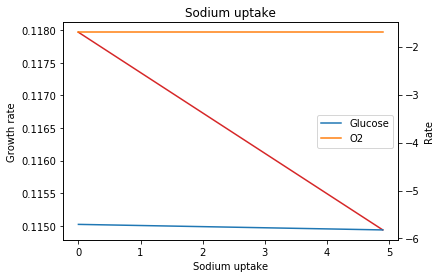

In [58]:
fig,ax1 = plt.subplots()
plt.title('Sodium uptake')

ax1.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['BIOMASS_BS_10'],
            label = 'growth',color='tab:red')
ax1.set_xlabel('Sodium uptake')
ax1.set_ylabel('Growth rate')

ax2 = ax1.twinx()
ax2.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['EX_o2_e'],
            label = 'Glucose')
ax2.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['EX_glc__D_e'],
            label = 'O2')
ax2.set_ylabel('Rate')

ax2.legend()

M-model predicts an increase in growth rate at increased sodium uptake

In [59]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)

In [60]:
flux_responses = pd.DataFrame.from_dict(flux_dict)

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:7 RuntimeWarning: invalid value encountered in true_divide


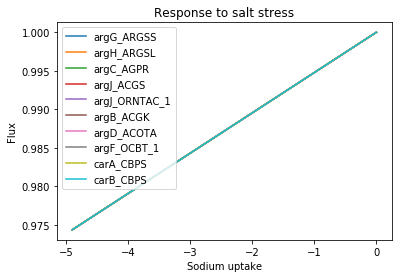

In [61]:
import pandas as pd
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(na_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('Response to salt stress')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()

Is it an artifact of growth rate increase?

In [64]:
bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = -10
bsub.reactions.get_by_id('BIOMASS_BS_10').lower_bound = base_mu
bsub.reactions.get_by_id('BIOMASS_BS_10').upper_bound = base_mu

bsub.objective = 'EX_glc__D_e'
bsub.reactions.get_by_id('EX_glc__D_e').objective_coefficient = -1.

# Sodium rates and simulation
na_rates = -np.arange(0,5,0.1)
flux_dict = dict()
for rate in na_rates:
    bsub.reactions.get_by_id('EX_na1_in').lower_bound = rate
    bsub.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:6 RuntimeWarning: invalid value encountered in true_divide


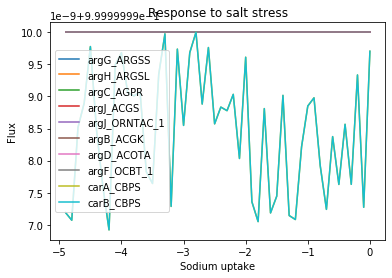

In [65]:
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(na_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('Response to salt stress')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()

In [66]:
flux_profile

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

M-model is not able to capture the decrease in AhrC regulon

## ME-model simulations

In [77]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [75]:
new_mu = me.solution.f

Add sodium uptake and exit separately

In [81]:
na1_e = me.metabolites.na1_e
## Separate sodium entrance and exit
me.reactions.EX_na1_e.lower_bound = 0
me.reactions.EX_na1_e.upper_bound = 0

# Create sodium metabolites
na1_in = cobrame.Metabolite(id='na1_in')
na1_out = cobrame.Metabolite(id='na1_out')
me.add_metabolites([na1_in,na1_out])

# Sodium uptake
rxn = cobrame.MEReaction(id='EX_na1_in')
rxn.add_metabolites({
    na1_in:-1.0
})
rxn.lower_bound = -1000
rxn.upper_bound = 0
me.add_reaction(rxn)
print(rxn.reaction)
# Sodium exit
rxn = cobrame.MEReaction(id='DM_na1_out')
rxn.add_metabolites({
    na1_out:-1.0
})
rxn.lower_bound = 0
rxn.upper_bound = 1000
me.add_reaction(rxn)
print(rxn.reaction)

na1_in <=> 
na1_out <=> 


In [84]:
uptake_rxns = get_reactions_of_met(me,'na1_e',s = -1,verbose=0)
exit_rxns = get_reactions_of_met(me,'na1_e',s = 1,verbose=0)

for rxn in uptake_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_in:coeff})
    print(rxn.reaction)
for rxn in exit_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_out:coeff})
    print(rxn.reaction)

bilea_e + na1_in <=> -0.000101135364372873*mu BSU19350-MONOMER + bilea_c + na1_c
mal__L_e + na1_in <=> -7.87506223338379e-5*mu BSU31580-MONOMER + mal__L_c + na1_c
3.0 na1_in + pi_e <=> -0.000103860411537506*mu BSU25420-MONOMER + 3.0 na1_c + pi_c
glu__L_e + na1_in <=> -4.27350427350427e-6*mu BSU09130-MONOMER + glu__L_c + na1_c
glu__L_e + na1_in <=> -8.11887730293195e-5*mu BSU10220-MONOMER + glu__L_c + na1_c
2.0 h_e + lac__L_c + mal__L_e + na1_c <=> -7.59309745207179e-5*mu BSU23560-MONOMER + 2.0 h_c + lac__L_e + mal__L_c + na1_out
h_e + na1_c <=> -4.27350427350427e-6*mu BSU33420-MONOMER + h_c + na1_out
h_e + na1_c <=> -4.27350427350427e-6*mu BSU31620-MONOMER + h_c + na1_out
h_e + na1_c <=> -4.27350427350427e-6*mu BSU31650-MONOMER + h_c + na1_out
h_e + na1_c <=> -4.27350427350427e-6*mu BSU31640-MONOMER + h_c + na1_out
h_e + na1_c <=> -4.27350427350427e-6*mu BSU31610-MONOMER + h_c + na1_out
h_e + na1_c <=> -4.27350427350427e-6*mu BSU09850-MONOMER + h_c + na1_out
atp_c + h2o_c + na1_c <=> -

Calculations

In [86]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('EX_na1_in').lower_bound = rate
    me.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [87]:
# Calculation at several sodium uptake rates
all_rxns = [rxn.id for rxn in me.reactions]
na_rates = -np.arange(0,5,0.5)
flux_dict = dict()
print('Rates to use: {}'.format(na_rates))

import multiprocessing as mp
NP = min([len(na_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in na_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Rates to use: [-0.  -0.5 -1.  -1.5 -2.  -2.5 -3.  -3.5 -4.  -4.5]
Calculating with 10 cores


,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.0
biomass_dilution,0.114956,0.114956,0.114956,0.114956,0.114956,0.114956,0.114956,0.114956,0.114956,0.114956
protein_biomass_to_biomass,0.019967,0.019767,0.019566,0.019365,0.019165,0.018964,0.018764,0.018573,0.018523,0.018470
mRNA_biomass_to_biomass,0.000068,0.000067,0.000067,0.000066,0.000065,0.000065,0.000064,0.000063,0.000063,0.000063
tRNA_biomass_to_biomass,0.000403,0.000399,0.000395,0.000391,0.000387,0.000383,0.000379,0.000375,0.000374,0.000373
rRNA_biomass_to_biomass,0.002979,0.002949,0.002919,0.002888,0.002858,0.002827,0.002797,0.002768,0.002761,0.002753


In [266]:
# Save results
flux_responses_me.to_csv('salt_flux_responses.csv',index_label='rxn_id')

In [267]:
flux_responses_me = pd.read_csv('salt_flux_responses.csv',index_col=0)

Text(0.5, 0, 'Sodium uptake')

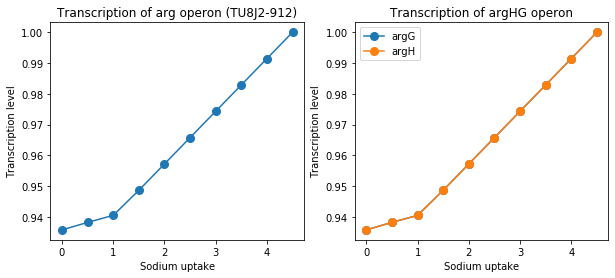

In [89]:
# Visualize transcription profiles
plt.figure(figsize=(10,4))

# TU8J2-912 operon: argCJBDF-carAB
plt.subplot(1,2,1)
expression = flux_responses_me.loc['transcription_TU8J2_912_from_BSU25200-MONOMER']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of arg operon (TU8J2-912)')
plt.ylabel('Transcription level')
plt.xlabel('Sodium uptake')

# argHG transcription
plt.subplot(1,2,2)
expression = flux_responses_me.loc['transcription_TU_BSU29450']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression), label='argG',
         marker = 'o',markersize=8)
expression = flux_responses_me.loc['transcription_TU_BSU29440']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression), label='argH',
         marker = 'o',markersize=8)
plt.legend()
plt.title('Transcription of argHG operon')
plt.ylabel('Transcription level')
plt.xlabel('Sodium uptake')

Text(0.5, 1.0, 'artPQR')

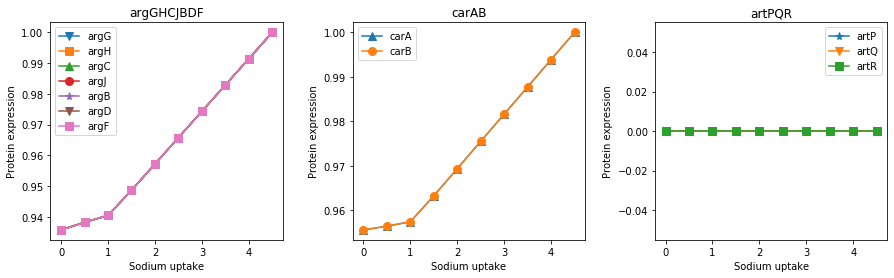

In [91]:
# Visualize protein expression profiles
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

flux_responses_me[abs(flux_responses_me)<1e-16] = 0

plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('argGHCJBDF')

plt.subplot(1,3,2)
genes = ['carA', 'carB']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('carAB')

plt.subplot(1,3,3)
genes = ['artP', 'artQ','artR']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('artPQR')

# artPQR are not included in the model

Notes:
* Sodium was forced to go through the model by creating na1_in and na1_out. Otherwise, it would have exited the model without going through the network from EX to DM